# Lasing in the deep-strong coupling regime of quantum electrodynamics: numerical steady-states from null eigenvector of the Liouvillian

The purpose of this notebook is to calculate the quantum state of a DSC system pumped by an inverted (gain) medium. This notebook focuses primarily on finding the steady state by setting up the Liouvillian of a DSC system pumped by a two-level system (which is continuously pumped). Spectra, eigenstates, steady-states, and various observables for the DSC (or DSC+emitter) system are computed using the QuantumOptics.jl package in Julia (see https://qojulia.org/ for documentation and examples). Note that this is in Julia 1.1 and so some functions may have changed if you use the newest version.

In [1]:
using LinearAlgebra
using DifferentialEquations
using QuantumOptics
using SparseArrays
using Arpack
using PyPlot
using GSL

In [2]:
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["font.size"] = 12;
rcParams["font.sans-serif"] = "Arial";

In [3]:
function stats(nvals,dist)
    
    n2vals = nvals.^2;
    
    nexp = sum(nvals.*dist);
    n2exp = sum(n2vals.*dist);
    
    dn = sqrt(n2exp-nexp^2);
    fano = dn^2/nexp;
    
    return nexp, dn, fano;
end

stats (generic function with 1 method)

# Rabi Hamiltonian in the deep strong coupling regime

The cell below sets up the Rabi Hamiltonian and diagonalizes it. The next lines build the matrix of eigenvectors, in order to enact a basis transformation into one in which the Rabi Hamiltonian is diagonal. This is referred to as the polariton basis.

Note that here, we have enough of a detuning to avoid crossings between the spin up and spin down DSC photon ladders. If you have no detuning, the spins cross. The only reason I mention this is that when associating a state index with the quantum numbers $n\sigma$ (as defined in the main text, Eq. (1)), when there is enough detuning, advancing the state index by 2 corresponds to advancing the DSC photon number by 1, while keeping the DSC photon spin fixed. If there is no detuning, that is not the case. Hence, when you turn the detuning off, you may notice that some of the plots look strange. This is why.

In [4]:
## Set up Hilbert space and various operators

b_atom = SpinBasis(1//2);

N_cutoff = 1000;
b_fock = FockBasis(N_cutoff);

σxa = sigmax(b_atom);
σya = sigmay(b_atom);
σza = sigmaz(b_atom);
σpa = sigmap(b_atom);
σma = sigmam(b_atom);
Ia = identityoperator(b_atom);

a = destroy(b_fock);
ad = create(b_fock);
n = number(b_fock);
Ip = identityoperator(b_fock);

a = destroy(b_fock);
ad = create(b_fock);
n = number(b_fock);
Ip = identityoperator(b_fock);

## Some example parameters

ωa = 1.0;
ωc = 1.0;
g = 5;
δ = 1e-1; #0e-1;

## Set up and diagonalize Rabi Hamiltonian

H_rabi = ωa/2*(σza ⊗ Ip) + δ/2*(σxa ⊗ Ip) + ωc*(Ia ⊗ n) + g*(σxa ⊗ (a+ad));
eigvals_rabi, eigstates_rabi = eigenstates(dense(H_rabi));

## Construct matrix of eigenvectors "eigmat"

rabi_dim = 2*(N_cutoff + 1);
eigmat = zeros(rabi_dim,rabi_dim);
rabi_mat = dense(H_rabi).data;

for ii=1:rabi_dim
    eigmat[:,ii] = eigstates_rabi[ii].data;
end

## Perform basis transformation from original basis to diagonal "polariton" or "DSC photon" basis

b_rabi = b_atom ⊗ b_fock;
D_rabi = DenseOperator(b_rabi,eigmat);
H_rabi_pol = dagger(D_rabi)*H_rabi*D_rabi;

## Representation of operators such as a, a^dagger ("ad"), x = a+ad, and Pauli σs in the diagonal (pol) basis. 

a_pol = dagger(D_rabi)*(Ia ⊗ a)*D_rabi;
ad_pol = dagger(D_rabi)*(Ia ⊗ ad)*D_rabi;
x_pol = a_pol + ad_pol;

σxpol = dagger(D_rabi)*(σxa ⊗ Ip)*D_rabi;
σzpol = dagger(D_rabi)*(σza ⊗ Ip)*D_rabi;


## A and Ad are displaced a and ad operators.

A = Ia ⊗ a + g*σxa ⊗ Ip;
Ad = Ia ⊗ ad + g*σxa ⊗ Ip;

The cells below compare the energy differences between adjacent states (of the same DSC photon "spin" quantum number $\sigma$ as defined in the main text, Eq. (1)) - between the perturbation theory expression and the exact diagonalization. We also compare the wavefunctions (in modulus, due to differing global phases). In both cases, the agreement is good.

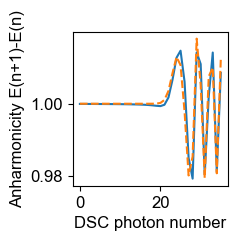

PyObject Text(25.07812500000002, 0.5, 'Anharmonicity E(n+1)-E(n)')

In [5]:
# # this shows that the lambdas work very well
figure(figsize=(2,2));
plot(diff(eigvals_rabi[2:2:75]))
plot([1 + 0.5*sqrt(δ^2 + (exp(-2*g^2)*sf_laguerre_n(ii+1,0,4*g^2))^2) - 0.5*sqrt(δ^2 + (exp(-2*g^2)*sf_laguerre_n(ii,0,4*g^2))^2) for ii=0:35],"--")
xlabel("DSC photon number")
ylabel("Anharmonicity E(n+1)-E(n)")

In [6]:
eigstates_x = eigenstates(dense(σxa));
spindown_x = eigstates_x[2][1]
spinup_x = eigstates_x[2][2];

Dg = displace(b_fock,g);
Ddg = displace(b_fock,-g);

θ(n) = atan(exp(-2g^2)*sf_laguerre_n(n,0,4*g^2)/δ);
eigst_down(n) =  sin(θ(n)/2)*spinup_x ⊗ (Ddg*fockstate(b_fock,n)) - cos(θ(n)/2)*spindown_x ⊗ (Dg*fockstate(b_fock,n));

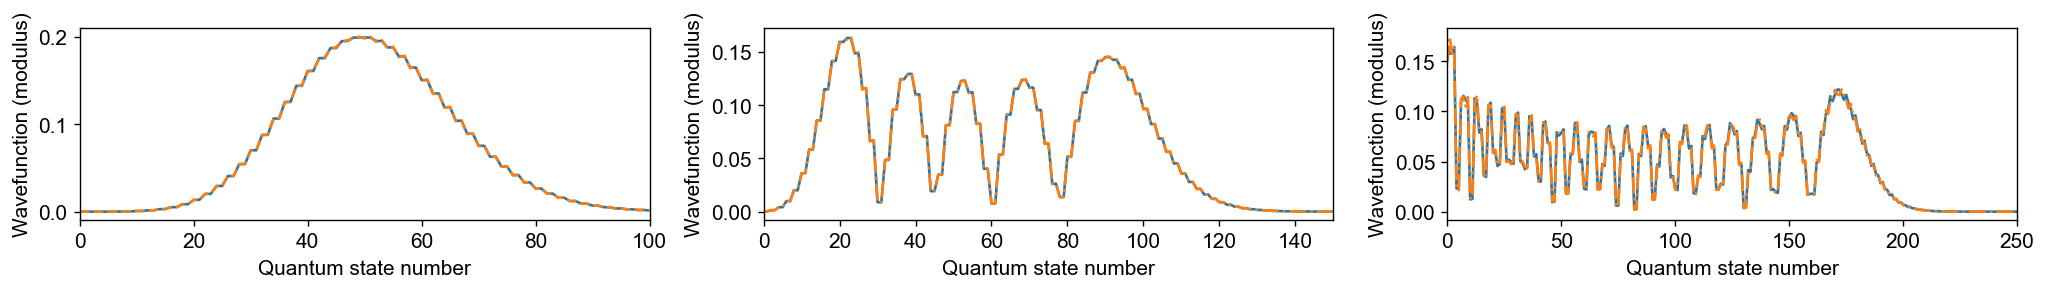

PyObject Text(1387.5220588235295, 0.5, 'Wavefunction (modulus)')

In [7]:
figure(dpi=125,figsize=(20,2));

# Spin-down, 0 DSC photons
subplot(1,3,1)
plot(abs.(eigst_down(0).data))
plot(abs.(eigstates_rabi[1].data),"--")
xlim(0,100)
xlabel("Quantum state number")
ylabel("Wavefunction (modulus)")

# Spin-down, 9 DSC photons (about halfway to nc)
subplot(1,3,2)
plot(abs.(eigst_down(4).data))
plot(abs.(eigstates_rabi[9].data),"-.")
xlim(0,150)
xlabel("Quantum state number")
ylabel("Wavefunction (modulus)")

# Spin-down, 20 DSC photons (similar to nc)
subplot(1,3,3)
plot(abs.(eigst_down(20).data))
plot(abs.(eigstates_rabi[41].data),"-.")
xlim(0,250)
xlabel("Quantum state number")
ylabel("Wavefunction (modulus)")

### Number matrix elements

Here we show the behavior expectation values of various operators in the Hilbert space. We consider the operators $a, n_a \equiv a^{\dagger}a$, as well as $b, n_b \equiv b^{\dagger}b$. The operator $b = a + g\sigma_x$ is such that the approximate DSC Hamiltonian (ignoring the $\sigma_{x,z}$ terms) is $\omega b^{\dagger}b$. Hence, $b$ is more like a counter for DSC photons than $a$ $-$ this is the purpose of the plots below. However, for $n \ll n_c$, the two operators more or less overlap.

Below, we calculate expectation values of $n_a$ and $n_b$ for the different spin-down DSC photon eigenstates $n$. In other words, matrix elements of the form $\langle n\sigma|X|n\sigma\rangle$, where $X$ is one of the operators mentioned above. We also calculate "cross-spin" matrix elements of the form $\langle n\sigma'|X|n\sigma\rangle$. And we calculate elements of the form $\langle n+1\sigma|X|n\sigma\rangle$.

In [8]:
indmax = 70;

na_elements = zeros(indmax);
nb_elements = zeros(indmax);
na_cross_elements = zeros(indmax);
nb_cross_elements = zeros(indmax);
na_2p_elements = zeros(indmax);
nb_2p_elements = zeros(indmax);

for ii=1:indmax
    st1 = eigstates_rabi[ii];
    st2 = eigstates_rabi[ii];
    na_elements[ii] = dagger(st2)*(Ia ⊗ n)*(st1) - g^2;
    nb_elements[ii] = dagger(st2)*(Ad*A)*(st1)
end

for ii=1:2:indmax
    st1 = eigstates_rabi[ii];
    st2 = eigstates_rabi[ii+1];
    na_cross_elements[ii] = dagger(st2)*(Ia ⊗ n)*(st1);
    nb_cross_elements[ii] = dagger(st2)*(Ad*A)*(st1)
end

for ii=1:2:indmax
    st1 = eigstates_rabi[ii];
    st2 = eigstates_rabi[ii+2];
    na_2p_elements[ii] = dagger(st2)*(Ia ⊗ n)*(st1);
    nb_2p_elements[ii] = dagger(st2)*(Ad*A)*(st1)
end

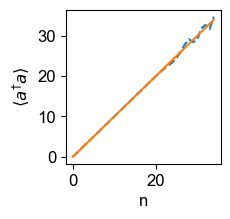

PyObject Text(31.9, 0.5, '$\\langle a^{\\dagger}a \\rangle$')

In [9]:
figure(figsize=(2,2));
plot(na_elements[1:2:end],"--")
plot(nb_elements[1:2:end],"-")
xlabel("n")
ylabel(L"\langle a^{\dagger}a \rangle")
#savefig("ada_vals_lam001.svg", format="svg")

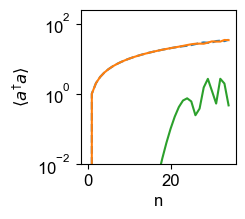

(0.01, 250)

In [10]:
figure(figsize=(2,2));
semilogy(na_elements[1:2:end],"--")
semilogy(na_elements[2:2:end],"-")
semilogy(abs.(na_cross_elements[1:2:end]))
semilogy(abs.(nb_cross_elements[1:2:end]))
xlabel("n")
ylabel(L"\langle a^{\dagger}a \rangle")
ylim(1e-2,250)

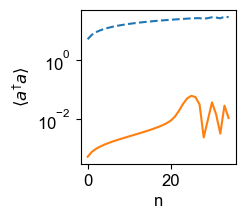

PyObject Text(31.89999999999999, 0.5, '$\\langle a^{\\dagger}a \\rangle$')

In [11]:
figure(figsize=(2,2));
semilogy(abs.(na_2p_elements[1:2:end]),"--")
semilogy(abs.(nb_2p_elements[1:2:end]))
xlabel("n")
ylabel(L"\langle a^{\dagger}a \rangle")

From the above, the main conclusions are that
- $b^{\dagger}b$ counts excitation number very accurately, even near the anharmonic part of the spectrum (first plot)
- The number operators negligibly couple different spins for $n \ll n_c$ and weakly couple them for $n\sim n_c$ (second plot)
- $b^{\dagger}b$ only weakly couples states of different DSC photon number, unlike $a^{\dagger}a$ (third plot)

### Coupling matrix elements

Below, we calculate expectation values of $a$ and $b$ between states of adjacent DSC photon number. The main conclusion is that for $n \ll n_c$, $\langle n|a,b|n+1\rangle = \sqrt{n+1}$ (leading to linear stimulated emission). Meanwhile, for $n \gtrsim n_c$, there are some deviations (they do not play much role in the major effect described in the text, since that mostly has to do with the structure of the detunings).

In [12]:
a_elements = zeros(indmax)
b_elements = zeros(indmax)

for ii=1:2:indmax
    st1 = eigstates_rabi[ii];
    st2 = eigstates_rabi[ii+2]; 
    a_elements[ii] = abs(dagger(st2)*(Ia ⊗ ad)*(st1))^2
    b_elements[ii] = abs(dagger(st2)*(Ad)*(st1))^2
    # println(abs(dagger(st2)*(Ad)*(st1))^2)
end

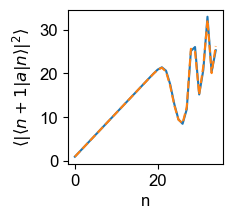

PyObject Text(33.90000000000001, 0.5, '$\\langle |\\langle n+1|a|n\\rangle|^2 \\rangle$')

In [13]:
figure(figsize=(2,2));
plot(a_elements[1:2:end])
plot(b_elements[1:2:end],"--")
xlabel("n")
ylabel(L"\langle |\langle n+1|a|n\rangle|^2 \rangle")

The cells below truncate the Hamiltonian (in the eigenbasis, not the original basis, the latter of which would require retaining many more states) to some maximum hilbert space dimension. We retain both spin-up and spin-down states. Various operators of interest are calculated in this basis. One operator we calculate is the positive frequency operator $X^{(+)} = (b+b^{\dagger})^{(+)}$. This is used in one case below as a jump operator for the DSC system (describing cavity leakage). You can optionally plot it with the commented lines below.

In [14]:
kmin = 1;
kmax = 70;#250

trunc_vals = eigvals_rabi[1:1:kmax];
trunc_states = eigstates_rabi[1:1:kmax];


b_rabi_trunc = SubspaceBasis(b_rabi, trunc_states)

P_trunc = projector(b_rabi_trunc, b_rabi);
Pd_trunc = dagger(P_trunc);
I_trunc = one(b_rabi_trunc);

H_trunc = P_trunc*H_rabi*Pd_trunc;
a_trunc = P_trunc*(Ia ⊗ a)*Pd_trunc;
ad_trunc = dagger(a_trunc);
A_trunc = P_trunc*A*Pd_trunc;
Ad_trunc = P_trunc*Ad*Pd_trunc;
n_trunc = P_trunc*(Ad*A)*Pd_trunc;
n2_trunc = P_trunc*((Ad*A)^2)*Pd_trunc;

X_plus_mat = A_trunc.data + Ad_trunc.data;
for nn = 1:kmax
    for mm = 1:kmax
        if mm >= nn
            X_plus_mat[mm,nn] = 0;
        end
    end
end

X_plus_mat;
X_plus = SparseOperator(b_rabi_trunc,droptol!(sparse(X_plus_mat),1e-16));

# figure(figsize=(2,2));
# imshow(abs.(X_plus.data)[1:60,1:60].^2)
# colorbar()

## Coupling of the DSC system to an emitter (a qubit weakly coupled to the DSC photon)

Now we consider the description of the dynamics of a qubit coupled to a DSC system. We couple the qubit directly to the DSC photon operator $b$ (which could result from coupling the qubit to the electric field of the cavity in which the DSC photon is formed). In the cell below, we set up the Hamiltonian of a two-level system coupled to a qubit-cavity system described by the Rabi model. We then transform into the eigenbasis of the joint system.

In [15]:
b_emit = SpinBasis(1//2);

b = b_emit ⊗ b_atom ⊗ b_fock;

σxe = sigmax(b_emit);
σye = sigmay(b_emit);
σze = sigmaz(b_emit);
σpe = sigmap(b_emit);
σme = sigmam(b_emit);
Ie = identityoperator(b_emit);

ϵ = 1e-5;
ωe = 1;

H =  Ie ⊗ H_rabi + ωe/2*(σze ⊗ Ia ⊗ Ip) + ϵ*(σxe ⊗ Ia ⊗ (a+ad));

H0 =  Ie ⊗ H_rabi + ωe/2*(σze ⊗ Ia ⊗ Ip);
V = ϵ*(σxe ⊗ Ia ⊗ (a+ad));

H_rwa =  Ie ⊗ H_rabi + ωe/2*(σze ⊗ Ia ⊗ Ip) + ϵ*(σpe ⊗ Ia ⊗ a) + ϵ*(σme ⊗ Ia ⊗ ad);
V_rwa = ϵ*(σpe ⊗ Ia ⊗ a) + ϵ*(σme ⊗ Ia ⊗ ad);

eigvals_H0, eigstates_H0 = eigenstates((1/2)*(dense(H0)+dense(dagger(H0))));
eigvals_H0;

total_dim = 2*2*(N_cutoff + 1);
eigmat_tot = zeros(total_dim,total_dim);

for ii=1:total_dim
    eigmat_tot[:,ii] = eigstates_H0[ii].data;
end

A = Ie ⊗ a + g*σxa ⊗ Ip;
Ad = Ie ⊗ ad + g*σxa ⊗ Ip;

D_tot = DenseOperator(b,eigmat_tot);
H0_pol_basis = dagger(D_tot)*H0*D_tot; #pol_basis means polariton basis
H_pol_basis = dagger(D_tot)*H*D_tot; #pol_basis means polariton basis
H_pol_basis_rwa = dagger(D_tot)*H_rwa*D_tot; #pol_basis means polariton basis
V_pol_basis = dagger(D_tot)*V*D_tot; #pol_basis means polariton basis
A_pol_basis = dagger(D_tot)*dense(Ie ⊗ A)*D_tot;

### Demonstration of spin-conserving nonlinear Jaynes-Cummings dynamics

Below, we calculate the "S" matrix of the system (the unitary time-evolution operator). By plotting the (element-wise) absolute square of the unitary evolution operator, we find the transition probabilities for various eigenstates. Subtracting off the identity (to form the matrix which we call "dP_mat") tells us the change in probability of the different eigenstates. Below, you will see that this matrix takes a block-diagonal structure. In particular, it says that the emitter (the weakly coupled qubit) only couples states of same DSC photon spin, and with DSC photon number differing by one. Therefore, the coupling of a weakly coupled qubit to the DSC photon is exactly the same (structurally) as the coupling of a qubit to a cavity as per the Jaynes-Cummings model.

However, what differs from the usual Jaynes-Cummings dynamics is that you will also see that the transition probabilities decay very rapidly beyond $n>n_c$ because the emitter falls rapidly out of resonance with the DSC photon, which becomes strongly anharmonic at this excitation number. This reproduces the nonlinear stimulated emission behavior plotted in Fig. 2.

This same matrix also shows that the DSC photon spin plays no role.

In [16]:
tf = 0.01/ϵ;
U_rwa = exp(-1im*(H_pol_basis)*tf).data; # RWA is not what creates these elements.
S_mat = real(U_rwa.*conj(U_rwa));
dP_mat = real(U_rwa.*conj(U_rwa)) - UniformScaling(1.0);

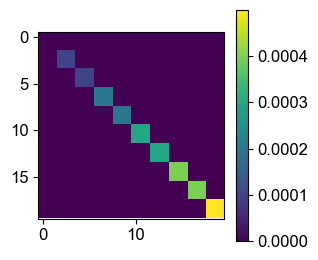

PyObject <matplotlib.colorbar.Colorbar object at 0x7fbaa82a0828>

In [17]:
figure(figsize=(3,3));
indmin = 1;
indmax = 20;
imshow(abs.(dP_mat[indmin:indmax,indmin:indmax]))
colorbar()

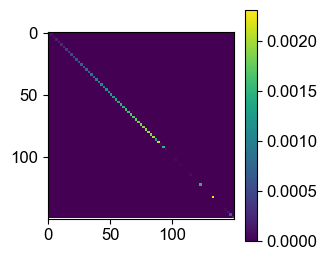

PyObject <matplotlib.colorbar.Colorbar object at 0x7fba9824da20>

In [18]:
figure(figsize=(3,3));
indmin = 1;
indmax = 150;
imshow(abs.(dP_mat[indmin:indmax,indmin:indmax]))
colorbar()

As you can see here, the dynamics all happen in 2-by-2 degenerate subspaces, meaning each spin is independent. We also see that the dynamics are totally suppressed beyond a photon number of about 20 (roughly state number 80), for any time, indicating rapidly falling out of resonance.

# Lasing in the deep strong coupling regime

Here, we calculate the steady state of a pumped qubit (emitter) coupled to a DSC system. Here we show the results of different possible couplings and jump operators on the spectrum, and you can see that in all cases, the system steady-state closely resembles a Fock state above threshold.

## Laser steady-state based on the lowest eigenvector of the Liouvillian

Note that numerically non-zero or very small matrix elements make the Liouvillian a lot larger than it needs to be (in terms of numbers of elements), and there is a quartic scaling, so it's better to drop small elements, then construct the Liouvillian. This case, with a 250 dimensional Hilbert space, takes ~30 min - 1 hr to construct the liouvillian and find the lowest eigenvalue. Large Hilbert spaces of more photons are not really approachable with this technique, but it gives exact validation of analytics which trade approximation for lower dimensionality.

Below, we plot the "unpolarized" DSC photon statistics (so each $n$-photon probability we plot sums over the probability of up-spin and down-spin).

Example of behavior slightly above threshold, yielding something resembling the "uniform" state described in the main text and arrived at on the basis of the analytical theory.

In [19]:
b_total_trunc = b_emit ⊗ b_rabi_trunc;

A_trunc_tot = Ie ⊗ A_trunc;
Ad_trunc_tot = Ie ⊗ Ad_trunc;
N_trunc_tot = Ie ⊗ n_trunc;
N2_trunc_tot = Ie ⊗ n2_trunc;

ϵ = 1e-5;
ωe = 1;

H_rwa_trunc = Ie ⊗ H_trunc + ωe/2*(σze ⊗ I_trunc) + ϵ*(σxe ⊗ (a_trunc + ad_trunc)); 
#H_rwa_trunc = Ie ⊗ H_trunc + ωe/2*(σze ⊗ I_trunc) + ϵ*(σxe ⊗ (A_trunc + Ad_trunc)); 

# H0_rwa_trunc = Ie ⊗ H_trunc + ωe/2*(σze ⊗ I_trunc);
# V_rwa_trunc = ϵ*(σpe ⊗ a_trunc) + ϵ*(σme ⊗ ad_trunc);

# eigvals_trunc, eigstates_trunc = eigenstates(0.5*dense(H0_rwa_trunc+dagger(H0_rwa_trunc)));

H_rwa_trunc_sp = SparseOperator(b_total_trunc,droptol!(sparse(H_rwa_trunc.data),ϵ/1000));

Γ = 0.0001;
r = 1.01*Γ;
κ = 1e-8;

jump_r = σpe ⊗ I_trunc;
jump_Γ = σme ⊗ I_trunc;
#jump_κ = Ie ⊗ (a_trunc + ad_trunc);
#jump_κ = Ie ⊗ (A_trunc);
jump_κ = Ie ⊗ (X_plus);

jump_rsp = SparseOperator(b_total_trunc,droptol!(sparse(jump_r.data),r/1000));
jump_Γsp = SparseOperator(b_total_trunc,droptol!(sparse(jump_Γ.data),Γ/1000));
jump_κsp = SparseOperator(b_total_trunc,droptol!(sparse(jump_κ.data),κ/1000));

jumps_sp = [jump_rsp, jump_Γsp, jump_κsp];
rates_sp = [r, Γ, κ];

liouville_op = liouvillian(H_rwa_trunc_sp, jumps_sp; rates=rates_sp);
liouville_mat = sparse(liouville_op).data;
droptol!(liouville_mat,1e-10);

minval = eigs(liouville_mat,nev = 1, which=:SM);

ρss = abs.(reshape(minval[2],(2*kmax,2*kmax)))
ρss = ρss/tr(ρss);

ρ_op = DenseOperator(b_total_trunc,ρss);
ρ_ph = ptrace(ρ_op,1);
p_ph = diag(ρ_ph.data);

nvals = [0:1:(kmax/2)-1;];
#ρ_at = ptrace(ρ_op,2);

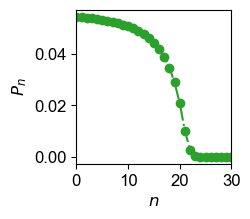

(0, 30)

In [20]:
figure(figsize=(2,2));
p_ph_unpol = [p_ph[ii] + p_ph[ii+1] for ii=1:2:kmax];
plot(nvals,p_ph_unpol,linestyle="-.",marker="o",color="C2")
xlabel(L"n")
ylabel(L"P_n")
xlim(0,30)
#savefig("lindblad_numerics_g10_high_nr.svg", format="svg")

Case well-above threshold.

In [21]:
b_total_trunc = b_emit ⊗ b_rabi_trunc;

A_trunc_tot = Ie ⊗ A_trunc;
Ad_trunc_tot = Ie ⊗ Ad_trunc;
N_trunc_tot = Ie ⊗ n_trunc;
N2_trunc_tot = Ie ⊗ n2_trunc;

ϵ = 1e-5;
ωe = 1;

H_rwa_trunc = Ie ⊗ H_trunc + ωe/2*(σze ⊗ I_trunc) + ϵ*(σxe ⊗ (a_trunc + ad_trunc)); 
#H_rwa_trunc = Ie ⊗ H_trunc + ωe/2*(σze ⊗ I_trunc) + ϵ*(σxe ⊗ (A_trunc + Ad_trunc)); 

# H0_rwa_trunc = Ie ⊗ H_trunc + ωe/2*(σze ⊗ I_trunc);
# V_rwa_trunc = ϵ*(σpe ⊗ a_trunc) + ϵ*(σme ⊗ ad_trunc);

# eigvals_trunc, eigstates_trunc = eigenstates(0.5*dense(H0_rwa_trunc+dagger(H0_rwa_trunc)));

H_rwa_trunc_sp = SparseOperator(b_total_trunc,droptol!(sparse(H_rwa_trunc.data),ϵ/1000));

Γ = 0.0001;
r = 10*Γ;
κ = 1e-8;

jump_r = σpe ⊗ I_trunc;
jump_Γ = σme ⊗ I_trunc;
#jump_κ = Ie ⊗ (a_trunc + ad_trunc);
#jump_κ = Ie ⊗ (A_trunc);
jump_κ = Ie ⊗ (X_plus);

jump_rsp = SparseOperator(b_total_trunc,droptol!(sparse(jump_r.data),r/1000));
jump_Γsp = SparseOperator(b_total_trunc,droptol!(sparse(jump_Γ.data),Γ/1000));
jump_κsp = SparseOperator(b_total_trunc,droptol!(sparse(jump_κ.data),κ/1000));

jumps_sp = [jump_rsp, jump_Γsp, jump_κsp];
rates_sp = [r, Γ, κ];

liouville_op = liouvillian(H_rwa_trunc_sp, jumps_sp; rates=rates_sp);
liouville_mat = sparse(liouville_op).data;
droptol!(liouville_mat,1e-10);

minval = eigs(liouville_mat,nev = 1, which=:SM);

ρss = abs.(reshape(minval[2],(2*kmax,2*kmax)))
ρss = ρss/tr(ρss);

ρ_op = DenseOperator(b_total_trunc,ρss);
ρ_ph = ptrace(ρ_op,1);
p_ph = diag(ρ_ph.data);

nvals = [0:1:(kmax/2)-1;];
#ρ_at = ptrace(ρ_op,2);

Below we plot the unpolarized DSC photon probability distribution and report the statistics (mean, uncertainty, and mandel Q parameter). As a reminder, a value of the mandel Q close to -1 indicates proximity to a Fock state.

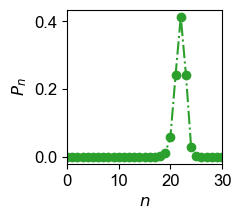

(0, 30)

In [22]:
figure(figsize=(2,2));
p_ph_unpol = [p_ph[ii] + p_ph[ii+1] for ii=1:2:kmax];
plot(nvals,p_ph_unpol,linestyle="-.",marker="o",color="C2")
xlabel(L"n")
ylabel(L"P_n")
xlim(0,30)

In [23]:
nexp = real(expect(n_trunc,ρ_ph))
n2exp = real(expect((n_trunc)^2,ρ_ph))
dn = sqrt(n2exp - nexp^2)
mandeln = (n2exp-nexp^2)/nexp-1
println("The mean DSC photon number is $(nexp)")
println("The uncertainty in DSC photon number is $(dn)")
println("The mandel Q parameter is $(mandeln)")

The mean DSC photon number is 21.913835255057492
The uncertainty in DSC photon number is 0.9980052845536972
The mandel Q parameter is -0.9545485974315137


For reference, here is what a below threshold state looks like.

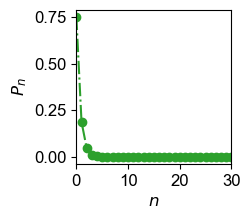

(0, 30)

In [24]:
Γ = 0.0001;
r = 0.25*Γ;
κ = 1e-8;

jump_r = σpe ⊗ I_trunc;
jump_Γ = σme ⊗ I_trunc;
#jump_κ = Ie ⊗ (a_trunc + ad_trunc);
#jump_κ = Ie ⊗ (A_trunc);
jump_κ = Ie ⊗ (X_plus);

jump_rsp = SparseOperator(b_total_trunc,droptol!(sparse(jump_r.data),r/1000));
jump_Γsp = SparseOperator(b_total_trunc,droptol!(sparse(jump_Γ.data),Γ/1000));
jump_κsp = SparseOperator(b_total_trunc,droptol!(sparse(jump_κ.data),κ/1000));

jumps_sp = [jump_rsp, jump_Γsp, jump_κsp];
rates_sp = [r, Γ, κ];

liouville_op = liouvillian(H_rwa_trunc_sp, jumps_sp; rates=rates_sp);
liouville_mat = sparse(liouville_op).data;
droptol!(liouville_mat,1e-10);

minval = eigs(liouville_mat,nev = 1, which=:SM);

ρss = abs.(reshape(minval[2],(2*kmax,2*kmax)))
ρss = ρss/tr(ρss);

ρ_op = DenseOperator(b_total_trunc,ρss);
ρ_ph = ptrace(ρ_op,1);
p_ph = diag(ρ_ph.data);

nvals = [0:1:(kmax/2)-1;];
#ρ_at = ptrace(ρ_op,2);

figure(figsize=(2,2));
p_ph_unpol = [p_ph[ii] + p_ph[ii+1] for ii=1:2:kmax];
plot(nvals,p_ph_unpol,linestyle="-.",marker="o",color="C2")
xlabel(L"n")
ylabel(L"P_n")
xlim(0,30)

Different choice of interaction. Little to no effect on plot.

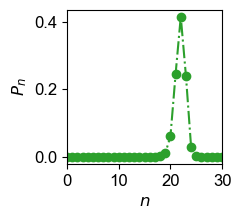

The mean DSC photon number is 21.904743474684743
The uncertainty in DSC photon number is 0.9985080853141542
The mandel Q parameter is -0.9544839044753028


In [25]:
b_total_trunc = b_emit ⊗ b_rabi_trunc;

A_trunc_tot = Ie ⊗ A_trunc;
Ad_trunc_tot = Ie ⊗ Ad_trunc;
N_trunc_tot = Ie ⊗ n_trunc;
N2_trunc_tot = Ie ⊗ n2_trunc;

ϵ = 1e-5;
ωe = 1;

# H_rwa_trunc = Ie ⊗ H_trunc + ωe/2*(σze ⊗ I_trunc) + ϵ*(σxe ⊗ (a_trunc + ad_trunc)); 
H_rwa_trunc = Ie ⊗ H_trunc + ωe/2*(σze ⊗ I_trunc) + ϵ*(σxe ⊗ (A_trunc + Ad_trunc)); 

# H0_rwa_trunc = Ie ⊗ H_trunc + ωe/2*(σze ⊗ I_trunc);
# V_rwa_trunc = ϵ*(σpe ⊗ a_trunc) + ϵ*(σme ⊗ ad_trunc);

# eigvals_trunc, eigstates_trunc = eigenstates(0.5*dense(H0_rwa_trunc+dagger(H0_rwa_trunc)));

H_rwa_trunc_sp = SparseOperator(b_total_trunc,droptol!(sparse(H_rwa_trunc.data),ϵ/1000));

Γ = 0.0001;
r = 10*Γ;
κ = 1e-8;

jump_r = σpe ⊗ I_trunc;
jump_Γ = σme ⊗ I_trunc;
#jump_κ = Ie ⊗ (a_trunc + ad_trunc);
#jump_κ = Ie ⊗ (A_trunc);
jump_κ = Ie ⊗ (X_plus);

jump_rsp = SparseOperator(b_total_trunc,droptol!(sparse(jump_r.data),r/1000));
jump_Γsp = SparseOperator(b_total_trunc,droptol!(sparse(jump_Γ.data),Γ/1000));
jump_κsp = SparseOperator(b_total_trunc,droptol!(sparse(jump_κ.data),κ/1000));

jumps_sp = [jump_rsp, jump_Γsp, jump_κsp];
rates_sp = [r, Γ, κ];

liouville_op = liouvillian(H_rwa_trunc_sp, jumps_sp; rates=rates_sp);
liouville_mat = sparse(liouville_op).data;
droptol!(liouville_mat,1e-10);

minval = eigs(liouville_mat,nev = 1, which=:SM);

ρss = abs.(reshape(minval[2],(2*kmax,2*kmax)))
ρss = ρss/tr(ρss);

ρ_op = DenseOperator(b_total_trunc,ρss);
ρ_ph = ptrace(ρ_op,1);
p_ph = diag(ρ_ph.data);

nvals = [0:1:(kmax/2)-1;];

figure(figsize=(2,2));
p_ph_unpol = [p_ph[ii] + p_ph[ii+1] for ii=1:2:kmax];
plot(nvals,p_ph_unpol,linestyle="-.",marker="o",color="C2")
xlabel(L"n")
ylabel(L"P_n")
xlim(0,30)

nexp = real(expect(n_trunc,ρ_ph))
n2exp = real(expect((n_trunc)^2,ρ_ph))
dn = sqrt(n2exp - nexp^2)
mandeln = (n2exp-nexp^2)/nexp-1
println("The mean DSC photon number is $(nexp)")
println("The uncertainty in DSC photon number is $(dn)")
println("The mandel Q parameter is $(mandeln)")
#ρ_at = ptrace(ρ_op,2);

Different choice of jump operator. Little to no effect on plot.

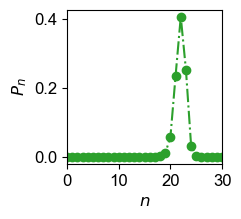

The mean DSC photon number is 21.947769765254
The uncertainty in DSC photon number is 1.0208060555005092
The mandel Q parameter is -0.9525215995022787


In [26]:
b_total_trunc = b_emit ⊗ b_rabi_trunc;

A_trunc_tot = Ie ⊗ A_trunc;
Ad_trunc_tot = Ie ⊗ Ad_trunc;
N_trunc_tot = Ie ⊗ n_trunc;
N2_trunc_tot = Ie ⊗ n2_trunc;

ϵ = 1e-5;
ωe = 1;

# H_rwa_trunc = Ie ⊗ H_trunc + ωe/2*(σze ⊗ I_trunc) + ϵ*(σxe ⊗ (a_trunc + ad_trunc)); 
H_rwa_trunc = Ie ⊗ H_trunc + ωe/2*(σze ⊗ I_trunc) + ϵ*(σxe ⊗ (A_trunc + Ad_trunc)); 

# H0_rwa_trunc = Ie ⊗ H_trunc + ωe/2*(σze ⊗ I_trunc);
# V_rwa_trunc = ϵ*(σpe ⊗ a_trunc) + ϵ*(σme ⊗ ad_trunc);

# eigvals_trunc, eigstates_trunc = eigenstates(0.5*dense(H0_rwa_trunc+dagger(H0_rwa_trunc)));

H_rwa_trunc_sp = SparseOperator(b_total_trunc,droptol!(sparse(H_rwa_trunc.data),ϵ/1000));

Γ = 0.0001;
r = 10*Γ;
κ = 1e-8;

jump_r = σpe ⊗ I_trunc;
jump_Γ = σme ⊗ I_trunc;
#jump_κ = Ie ⊗ (a_trunc + ad_trunc);
jump_κ = Ie ⊗ (A_trunc);
# jump_κ = Ie ⊗ (X_plus);

jump_rsp = SparseOperator(b_total_trunc,droptol!(sparse(jump_r.data),r/1000));
jump_Γsp = SparseOperator(b_total_trunc,droptol!(sparse(jump_Γ.data),Γ/1000));
jump_κsp = SparseOperator(b_total_trunc,droptol!(sparse(jump_κ.data),κ/1000));

jumps_sp = [jump_rsp, jump_Γsp, jump_κsp];
rates_sp = [r, Γ, κ];

liouville_op = liouvillian(H_rwa_trunc_sp, jumps_sp; rates=rates_sp);
liouville_mat = sparse(liouville_op).data;
droptol!(liouville_mat,1e-10);

minval = eigs(liouville_mat,nev = 1, which=:SM);

ρss = abs.(reshape(minval[2],(2*kmax,2*kmax)))
ρss = ρss/tr(ρss);

ρ_op = DenseOperator(b_total_trunc,ρss);
ρ_ph = ptrace(ρ_op,1);
p_ph = diag(ρ_ph.data);

nvals = [0:1:(kmax/2)-1;];

figure(figsize=(2,2));
p_ph_unpol = [p_ph[ii] + p_ph[ii+1] for ii=1:2:kmax];
plot(nvals,p_ph_unpol,linestyle="-.",marker="o",color="C2")
xlabel(L"n")
ylabel(L"P_n")
xlim(0,30)

nexp = real(expect(n_trunc,ρ_ph))
n2exp = real(expect((n_trunc)^2,ρ_ph))
dn = sqrt(n2exp - nexp^2)
mandeln = (n2exp-nexp^2)/nexp-1
println("The mean DSC photon number is $(nexp)")
println("The uncertainty in DSC photon number is $(dn)")
println("The mandel Q parameter is $(mandeln)")
#ρ_at = ptrace(ρ_op,2);

Same as above but repeating the process for larger $g$.

### Setup

In [27]:
b_emit = SpinBasis(1//2);
b_atom = SpinBasis(1//2);

N_cutoff = 1000;
b_fock = FockBasis(N_cutoff);

b = b_emit ⊗ b_atom ⊗ b_fock;

σxe = sigmax(b_emit);
σye = sigmay(b_emit);
σze = sigmaz(b_emit);
σpe = sigmap(b_emit);
σme = sigmam(b_emit);
Ie = identityoperator(b_emit);

σxa = sigmax(b_atom);
σya = sigmay(b_atom);
σza = sigmaz(b_atom);
σpa = sigmap(b_atom);
σma = sigmam(b_atom);
Ia = identityoperator(b_atom);

a = destroy(b_fock);
ad = create(b_fock);
n = number(b_fock);
Ip = identityoperator(b_fock);

ωa = 1#1.0;
ωc = 1.0;
g = 9;
δ = 1e-1;

H_rabi = ωa/2*(σza ⊗ Ip) + δ/2*(σxa ⊗ Ip) + ωc*(Ia ⊗ n) + g*(σxa ⊗ (a+ad));
eigvals_rabi, eigstates_rabi = eigenstates(dense(H_rabi));

rabi_dim = 2*(N_cutoff + 1);
eigmat = zeros(rabi_dim,rabi_dim);
rabi_mat = dense(H_rabi).data;

for ii=1:rabi_dim
    eigmat[:,ii] = eigstates_rabi[ii].data;
end

b_rabi = b_atom ⊗ b_fock;
D_rabi = DenseOperator(b_rabi,eigmat);
H_rabi_pol = dagger(D_rabi)*H_rabi*D_rabi;

a_pol = dagger(D_rabi)*(Ia ⊗ a)*D_rabi;
ad_pol = dagger(D_rabi)*(Ia ⊗ ad)*D_rabi;

A = Ie ⊗ a + g*σxa ⊗ Ip;
Ad = Ie ⊗ ad + g*σxa ⊗ Ip;

D = Ie ⊗ D_rabi;

In [28]:
kmin = 1;
kmax = 200;

trunc_vals = eigvals_rabi[1:1:kmax];
trunc_states = eigstates_rabi[1:1:kmax];

b_rabi_trunc = SubspaceBasis(b_rabi, trunc_states)

P_trunc = projector(b_rabi_trunc, b_rabi);
Pd_trunc = dagger(P_trunc);
I_trunc = one(b_rabi_trunc);

H_trunc = P_trunc*H_rabi*Pd_trunc;
a_trunc = P_trunc*(Ia ⊗ a)*Pd_trunc;
ad_trunc = dagger(a_trunc);
A_trunc = P_trunc*A*Pd_trunc;
Ad_trunc = P_trunc*Ad*Pd_trunc;
n_trunc = P_trunc*(Ad*A)*Pd_trunc;
n2_trunc = P_trunc*((Ad*A)^2)*Pd_trunc;

X_plus_mat = A_trunc.data + Ad_trunc.data;
for nn = 1:kmax
    for mm = 1:kmax
        if mm >= nn
            X_plus_mat[mm,nn] = 0;
        end
    end
end

X_plus_mat;
X_plus = SparseOperator(b_rabi_trunc,droptol!(sparse(X_plus_mat),1e-16));

In [29]:
ϵ = 1e-5;
ωe = 1;

b_total_trunc = b_emit ⊗ b_rabi_trunc;

A_trunc_tot = Ie ⊗ A_trunc;
Ad_trunc_tot = Ie ⊗ Ad_trunc;
N_trunc_tot = Ie ⊗ n_trunc;
N2_trunc_tot = Ie ⊗ n2_trunc;

H_rwa_trunc = Ie ⊗ H_trunc + ωe/2*(σze ⊗ I_trunc) + ϵ*(σxe ⊗ (A_trunc + Ad_trunc)); 
H_rwa_trunc_sp = SparseOperator(b_total_trunc,droptol!(sparse(H_rwa_trunc.data),ϵ/1000));

### Numerical steady-state

In [30]:
Γ = 1e-4;
r = 10*Γ;
κ = 1e-8;

jump_r = σpe ⊗ I_trunc;
jump_Γ = σme ⊗ I_trunc;
jump_κ = Ie ⊗ A_trunc;

jump_rsp = SparseOperator(b_total_trunc,droptol!(sparse(jump_r.data),r/1000));
jump_Γsp = SparseOperator(b_total_trunc,droptol!(sparse(jump_Γ.data),Γ/1000));
jump_κsp = SparseOperator(b_total_trunc,droptol!(sparse(jump_κ.data),κ/1000));

jumps_sp = [jump_rsp, jump_Γsp, jump_κsp];
rates_sp = [r, Γ, κ];

liouville_op = liouvillian(H_rwa_trunc_sp, jumps_sp; rates=rates_sp);
liouville_mat = sparse(liouville_op).data;
droptol!(liouville_mat,1e-10);

minval = eigs(liouville_mat,nev = 1, which=:SM);

ρss = abs.(reshape(minval[2],(2*kmax,2*kmax)))
ρss = ρss/tr(ρss);

ρ_op = DenseOperator(b_total_trunc,ρss);
ρ_ph = ptrace(ρ_op,1);
p_ph = diag(ρ_ph.data);

nvals = [0:1:(kmax/2)-1;];

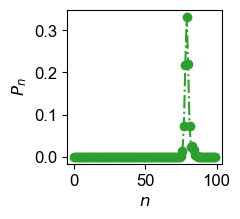

PyObject Text(28.699999999999996, 0.5, '$P_n$')

In [31]:
figure(figsize=(2,2));
p_ph_unpol = [p_ph[ii] + p_ph[ii+1] for ii=1:2:kmax];
plot(nvals,p_ph_unpol,linestyle="-.",marker="o",color="C2")
xlabel(L"n")
ylabel(L"P_n")
#xlim(90,100)

In [32]:
nexp = real(expect(n_trunc,ρ_ph))
n2exp = real(expect((n_trunc)^2,ρ_ph))
dn = n2exp - nexp^2;
mandeln = (n2exp-nexp^2)/nexp-1
println("The mean DSC photon number is $(nexp)")
println("The uncertainty in DSC photon number is $(dn)")
println("The mandel Q parameter is $(mandeln)")

The mean DSC photon number is 79.23346895894169
The uncertainty in DSC photon number is 2.3827480154304794
The mandel Q parameter is -0.9699275060559925


And one last case. This time, no detuning (so no spin-splitting), and a higher $g$. Note you should feel free to play with the truncation "kmax" as well. Adjusting kmax from 220 to 250 leads to no change.

In [33]:
b_emit = SpinBasis(1//2);
b_atom = SpinBasis(1//2);

N_cutoff = 1000;
b_fock = FockBasis(N_cutoff);

b = b_emit ⊗ b_atom ⊗ b_fock;

σxe = sigmax(b_emit);
σye = sigmay(b_emit);
σze = sigmaz(b_emit);
σpe = sigmap(b_emit);
σme = sigmam(b_emit);
Ie = identityoperator(b_emit);

σxa = sigmax(b_atom);
σya = sigmay(b_atom);
σza = sigmaz(b_atom);
σpa = sigmap(b_atom);
σma = sigmam(b_atom);
Ia = identityoperator(b_atom);

a = destroy(b_fock);
ad = create(b_fock);
n = number(b_fock);
Ip = identityoperator(b_fock);

ωa = 1#1.0;
ωc = 1.0;
g = 10;
δ = 0e-1;

H_rabi = ωa/2*(σza ⊗ Ip) + δ/2*(σxa ⊗ Ip) + ωc*(Ia ⊗ n) + g*(σxa ⊗ (a+ad));
eigvals_rabi, eigstates_rabi = eigenstates(dense(H_rabi));

rabi_dim = 2*(N_cutoff + 1);
eigmat = zeros(rabi_dim,rabi_dim);
rabi_mat = dense(H_rabi).data;

for ii=1:rabi_dim
    eigmat[:,ii] = eigstates_rabi[ii].data;
end

b_rabi = b_atom ⊗ b_fock;
D_rabi = DenseOperator(b_rabi,eigmat);
H_rabi_pol = dagger(D_rabi)*H_rabi*D_rabi;

a_pol = dagger(D_rabi)*(Ia ⊗ a)*D_rabi;
ad_pol = dagger(D_rabi)*(Ia ⊗ ad)*D_rabi;

A = Ie ⊗ a + g*σxa ⊗ Ip;
Ad = Ie ⊗ ad + g*σxa ⊗ Ip;

D = Ie ⊗ D_rabi;

kmin = 1;
kmax = 220;

trunc_vals = eigvals_rabi[1:1:kmax];
trunc_states = eigstates_rabi[1:1:kmax];

b_rabi_trunc = SubspaceBasis(b_rabi, trunc_states)

P_trunc = projector(b_rabi_trunc, b_rabi);
Pd_trunc = dagger(P_trunc);
I_trunc = one(b_rabi_trunc);

H_trunc = P_trunc*H_rabi*Pd_trunc;
a_trunc = P_trunc*(Ia ⊗ a)*Pd_trunc;
ad_trunc = dagger(a_trunc);
A_trunc = P_trunc*A*Pd_trunc;
Ad_trunc = P_trunc*Ad*Pd_trunc;
n_trunc = P_trunc*(Ad*A)*Pd_trunc;
n2_trunc = P_trunc*((Ad*A)^2)*Pd_trunc;

X_plus_mat = A_trunc.data + Ad_trunc.data;
for nn = 1:kmax
    for mm = 1:kmax
        if mm >= nn
            X_plus_mat[mm,nn] = 0;
        end
    end
end

X_plus_mat;
X_plus = SparseOperator(b_rabi_trunc,droptol!(sparse(X_plus_mat),1e-16));

ϵ = 1e-5;
ωe = 1;

b_total_trunc = b_emit ⊗ b_rabi_trunc;

A_trunc_tot = Ie ⊗ A_trunc;
Ad_trunc_tot = Ie ⊗ Ad_trunc;
N_trunc_tot = Ie ⊗ n_trunc;
N2_trunc_tot = Ie ⊗ n2_trunc;

H_rwa_trunc = Ie ⊗ H_trunc + ωe/2*(σze ⊗ I_trunc) + ϵ*(σxe ⊗ (A_trunc + Ad_trunc)); 
H_rwa_trunc_sp = SparseOperator(b_total_trunc,droptol!(sparse(H_rwa_trunc.data),ϵ/1000));

Γ = 1e-4;
r = 10*Γ;
κ = 1e-8;

jump_r = σpe ⊗ I_trunc;
jump_Γ = σme ⊗ I_trunc;
jump_κ = Ie ⊗ A_trunc;

jump_rsp = SparseOperator(b_total_trunc,droptol!(sparse(jump_r.data),r/1000));
jump_Γsp = SparseOperator(b_total_trunc,droptol!(sparse(jump_Γ.data),Γ/1000));
jump_κsp = SparseOperator(b_total_trunc,droptol!(sparse(jump_κ.data),κ/1000));

jumps_sp = [jump_rsp, jump_Γsp, jump_κsp];
rates_sp = [r, Γ, κ];

liouville_op = liouvillian(H_rwa_trunc_sp, jumps_sp; rates=rates_sp);
liouville_mat = sparse(liouville_op).data;
droptol!(liouville_mat,1e-10);

minval = eigs(liouville_mat,nev = 1, which=:SM);

ρss = abs.(reshape(minval[2],(2*kmax,2*kmax)))
ρss = ρss/tr(ρss);

ρ_op = DenseOperator(b_total_trunc,ρss);
ρ_ph = ptrace(ρ_op,1);
p_ph = diag(ρ_ph.data);

nvals = [0:1:(kmax/2)-1;];

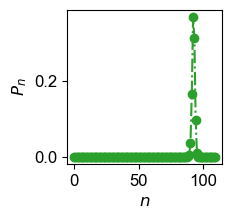

PyObject Text(28.699999999999996, 0.5, '$P_n$')

In [34]:
figure(figsize=(2,2));
p_ph_unpol = [p_ph[ii] + p_ph[ii+1] for ii=1:2:kmax];
plot(nvals,p_ph_unpol,linestyle="-.",marker="o",color="C2")
xlabel(L"n")
ylabel(L"P_n")

In [35]:
## run for kmax = 220

nexp = real(expect(n_trunc,ρ_ph))
n2exp = real(expect((n_trunc)^2,ρ_ph))
dn = n2exp - nexp^2;
mandeln = (n2exp-nexp^2)/nexp-1
println("The mean DSC photon number is $(nexp)")
println("The uncertainty in DSC photon number is $(dn)")
println("The mandel Q parameter is $(mandeln)")

The mean DSC photon number is 92.28001039898645
The uncertainty in DSC photon number is 1.1186799006482033
The mandel Q parameter is -0.9878773323083577


Feel free to adjust kmax to 250 to see the change in say the mandel Q parameter. I arrived at a change in about 0.01% for that and a change of about 1% in the uncertainty.